 GROUP COMPONENTS:
- Tito Tamburini
- Angelo Mandara
- Enrico Grimaldi
- Claudiu Gabriel Gheorghiu
- Giuseppe Di Poce


# Fraudulent Transactions Detection

### Context
We are going to develop a model for predicting fraudulent transactions for a financial company and use insights from the model to develop an actionable plan.

### Content

Data Dictionary:

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

Useful packages import

In [210]:
import pandas as pd
import numpy as np
from numpy import median
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor #multi-collinearity
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

**Exploratory Data Analysis (EDA)** 

In [211]:
# Reading the csv file
data=pd.read_csv('Fraud.csv')

In [212]:
#Let's take a look to the data
data.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


In [213]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There are no missing values in our dataset but we must remember that, as already said before, "oldbalanceDest" and "newbalanceDest" have not information for customers that start with M (Merchants).

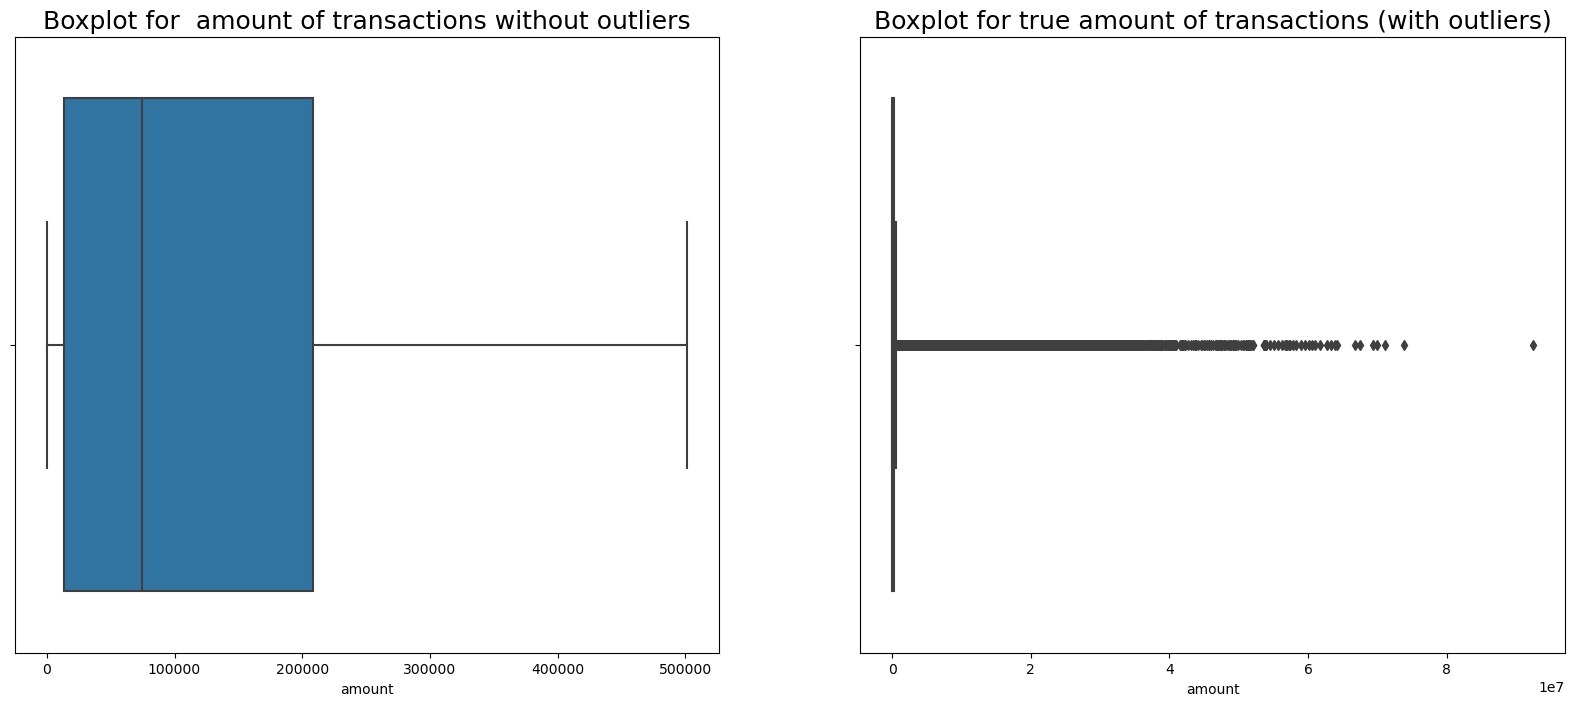

In [214]:
plt.figure(figsize=(20, 8))

one = plt.subplot(1, 2, 1)
one.set_title("Boxplot for  amount of transactions without outliers", 
             {"fontsize":18})
sns.boxplot(x=data["amount"],showfliers = False)

two = plt.subplot(1, 2, 2)
two.set_title("Boxplot for true amount of transactions (with outliers)", 
             {"fontsize":18})
sns.boxplot(x=data["amount"],showfliers = True)

plt.show()

Observing on the right the "true" **amount** is heavy the presence of outliers: the box is flat. Visually the imagine on the left tells us expicitely the distibution it's strongly asymmetric (mean > median). The most (75%) of transactions are under 208'722$, on average 179'862$, 50% < 74'872$.
In the next cell the statistics. 

In [215]:
print(data.amount.describe().to_markdown())
print("Median : " + str(median(data.amount)))

|       |           amount |
|:------|-----------------:|
| count |      6.36262e+06 |
| mean  | 179862           |
| std   | 603858           |
| min   |      0           |
| 25%   |  13389.6         |
| 50%   |  74871.9         |
| 75%   | 208721           |
| max   |      9.24455e+07 |
Median : 74871.94


Let's take a look at the number of fraud and legit transaction. Then more strictly which types are the "dangerous".

In [216]:
print("In absolute : \n" + str(data.isFraud.value_counts()))
print("In proportion : \n" + str(data.isFraud.value_counts(1)))

In absolute : 
0    6354407
1       8213
Name: isFraud, dtype: int64
In proportion : 
0    0.998709
1    0.001291
Name: isFraud, dtype: float64


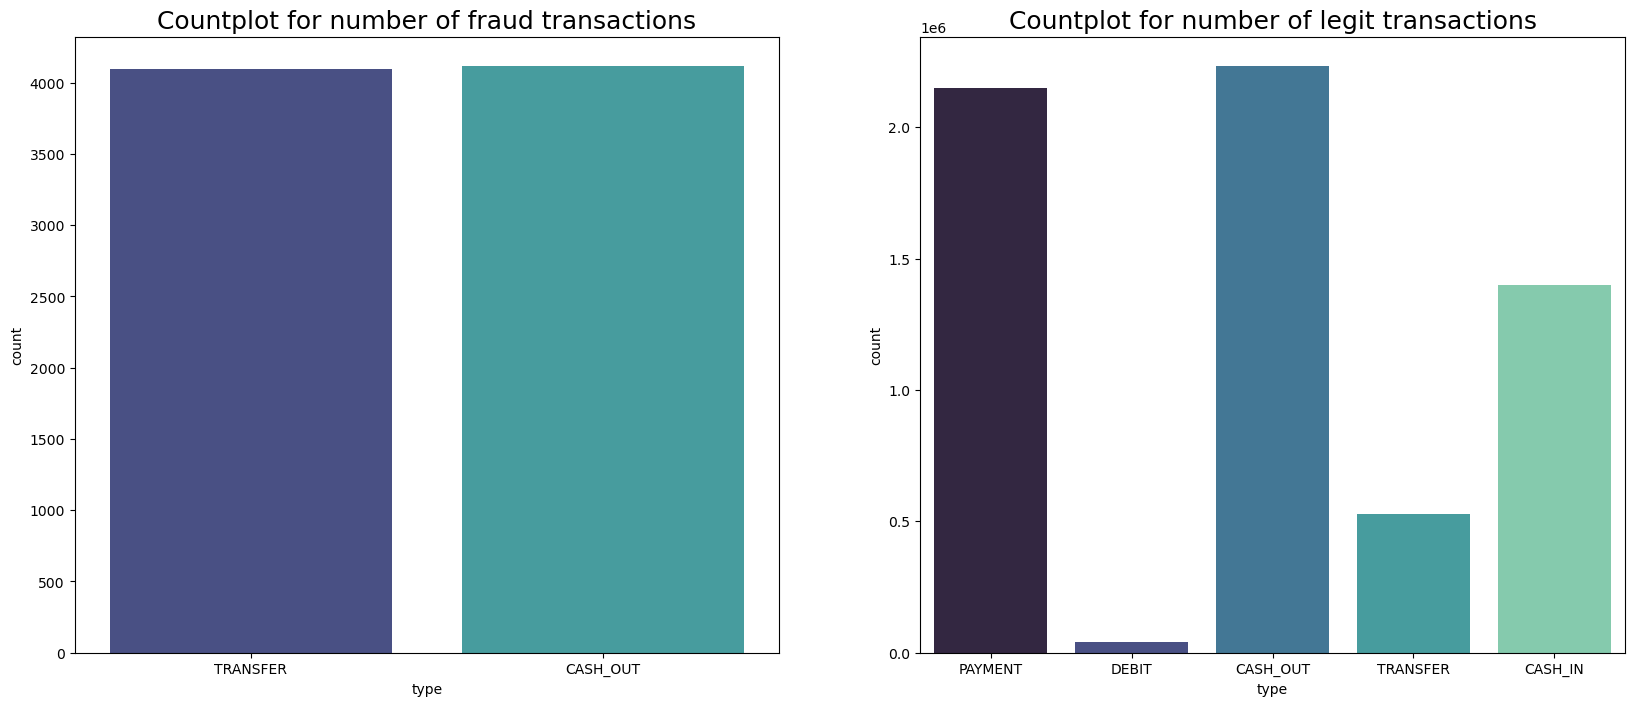

In [217]:
# dataset divided by isFraud
F=data[data.isFraud==1]
NF=data[data.isFraud==0]


plt.figure(figsize=(20, 8))

one = plt.subplot(1, 2, 1)
one.set_title("Countplot for number of fraud transactions", 
             {"fontsize":18})
sns.countplot(F.type, palette='mako')

two = plt.subplot(1, 2, 2)
two.set_title("Countplot for number of legit transactions", 
             {"fontsize":18})
sns.countplot(NF.type, palette='mako')

plt.show()

In [218]:
print("Number of not fraud transaction per type : \n " + str(NF.type.value_counts()) + "\n")
print("Number of fraud transaction per type : \n " + str(F.type.value_counts()))

Number of not fraud transaction per type : 
 CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64

Number of fraud transaction per type : 
 CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64


The number of fraud movements is 8213, the 0.1% of the total. They are divided between the types "CASH_OUT" and "TRANSER" and respect to the amount mostly present with small ones.

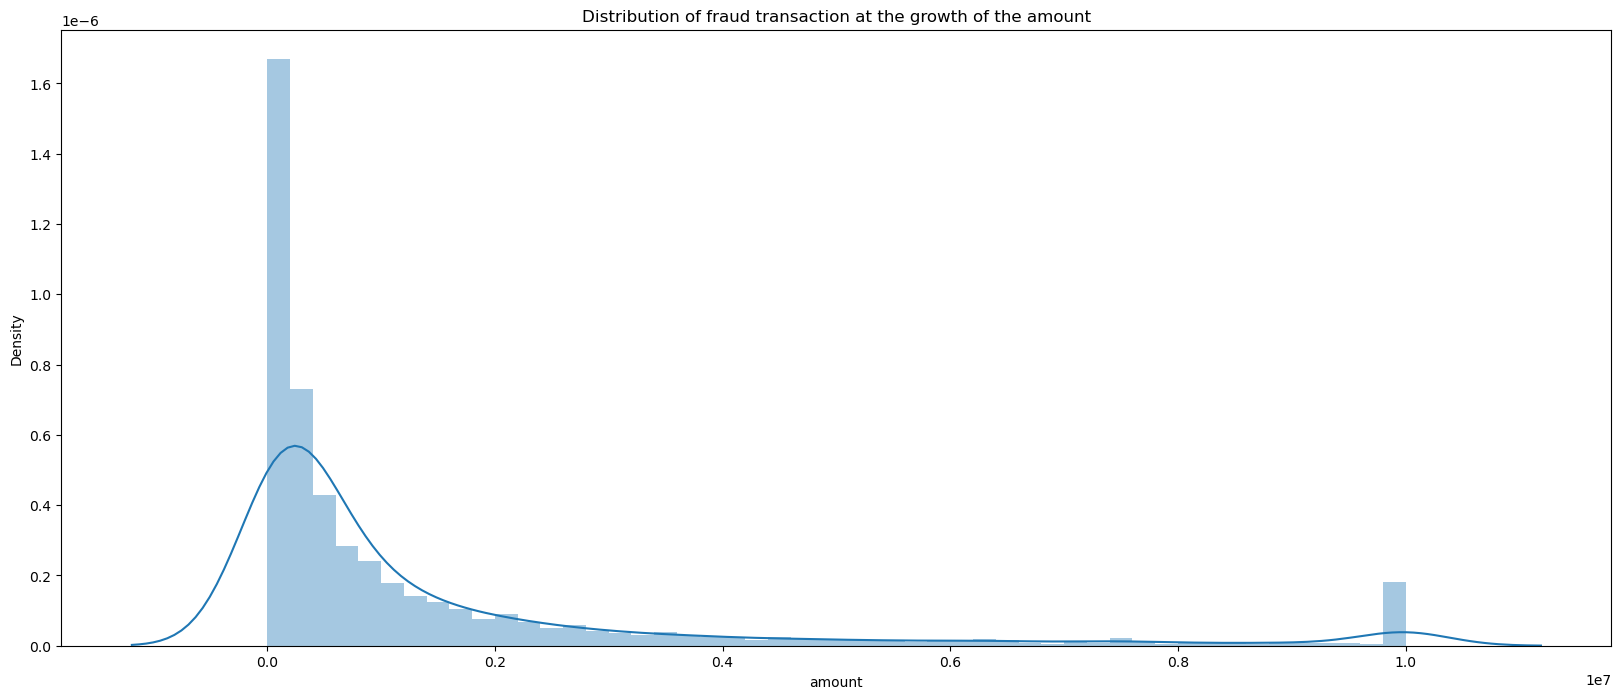

In [219]:
plt.figure(figsize=(20, 8))
sns.distplot(F['amount'])
plt.title("Distribution of fraud transaction at the growth of the amount", fontdict=None, loc='center')
plt.show()

In [220]:
print("Total Unique Values in nameOrig", data['nameOrig'].nunique())

Total Unique Values in nameOrig 6353307


In [221]:
print("Total Unique Values in nameDest", data['nameDest'].nunique())

Total Unique Values in nameDest 2722362


In [222]:
data.isFlaggedFraud.value_counts() #we will drop this column because irrilevant

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [223]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


3 categorical objects: step, nameOrig, nameDest.
### Feature engineering

In [224]:
len(data.loc[data['nameDest'].apply(lambda x: x[0]=='C')])+len(data.loc[data['nameDest'].apply(lambda x: x[0]=='M')])==len(data)
# just M and C

True

In [225]:
types = pd.get_dummies(data.type, prefix='type', drop_first=True)
#By dropping one of the one-hot encoded columns from each categorical feature, we ensure there are no "reference" columns and the remaining columns become linearly independent.
types.head()

,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,0,1,0
1,0,0,1,0
2,0,0,0,1
3,1,0,0,0
4,0,0,1,0


In [226]:
data['nameOrig'] = le.fit_transform(data['nameOrig'])
data['nameDest'] = le.fit_transform(data['nameDest'])

#class sklearn.preprocessing.LabelEncoder: encodes labels with value between 0 and n_classes-1 (remove one dummy variable column, known as the reference, to avoid "dummy trap" of redundancy)

In [227]:
data[['nameOrig', 'nameDest']]

,nameOrig,nameDest
0,757869,1662094
1,2188998,1733924
2,1002156,439685
3,5828262,391696
4,3445981,828919
...,...,...
6362615,5651847,505863
6362616,1737278,260949
6362617,533958,108224
6362618,2252932,319713


In [228]:
#putting all together
data = pd.concat([data, types], axis=1)
data = data.drop('type', axis=1)
data.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0,0,0,1,0
2,1,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0,0,0,0,1
3,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0,0,0,1,0


Let's take an important step to get the basis to our model: how do the variables behave respect to each other?

### Correlation

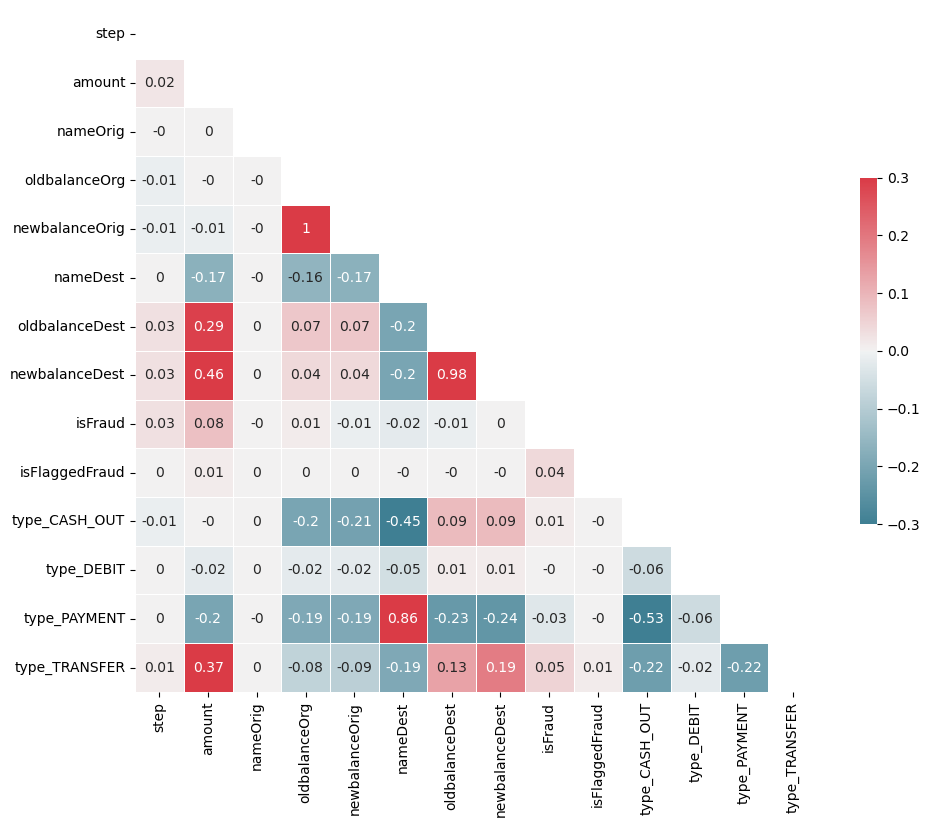

In [229]:
f, ax = plt.subplots(figsize=(11, 9))
#sns.heatmap(data.corr(), cmap='mako', linewidth=0.2, annot=True)
#plt.show()

corr=round(data.corr(),2)

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    corr,          # The data to plot
    mask=mask,     # Mask some cells
    cmap=cmap,     # What colors to plot the heatmap as
    annot=True,    # Should the values be plotted in the cells?
    vmax=.3,       # The maximum value of the legend. All higher vals will be same color
    vmin=-.3,      # The minimum value of the legend. All lower vals will be same color
    center=0,      # The center value of the legend. With divergent cmap, where white is
    square=True,   # Force cells to be square
    linewidths=.5, # Width of lines that divide cells
    cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
)
plt.show()

The existence of collinearity inflates the variances of the parameter estimates, and consequently incorrect inferences about relationships between explanatory and response variables. Examining the correlation matrix may be helpful to detect multicollinearity, but not sufficient. Much better diagnostics are produced by linear regression with **VIF**.

### Multi-Collinearity analysis

In statistics, **multicollinearity** (also collinearity) is a phenomenon in which one predictor variable in a multiple regression model can be linearly predicted from the others with a degree of accuracy. The coefficient estimates of the multiple regression may change erratically in response to small changes in the model or the data. Multicollinearity does not reduce the predictive power or reliability of the model as a whole; it only affects calculations regarding individual predictors. That is, a multivariate regression model with collinear predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others.

"No multicollinearity" refers to the absence of perfect multicollinearity, which is an exact (non-stochastic) linear relation among the predictors. In such a case, the design matrix $X$ has less than full rank, and therefore the moment matrix $X^{T}X$ cannot be inverted. Under these circumstances, for a general linear model $y=X\beta +\epsilon$ , the ordinary least squares estimator  $\hat{\beta }_{OLS}=(X^{T}X)^{-1}X^{T}$ does not exist.

A formal detection-tolerance for the variance inflation factor (VIF) for multicollinearity is given by:

**tolerance** $= 1-R_{j}^{2}$      ,              **VIF** $ =\frac{1}{tolerance}$

where $R_{j}^{2}$ is the "coefficient of determination" of a regression (proportion of the variation in the dependent variable that is predictable from the independent variables)  of explanator j on all the other explanators. A tolerance of less than 0.20 or 0.10 and/or a VIF of 5 or 10 and above indicates a multicollinearity problem.

In [230]:
data.columns

Index(['step', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER'],
      dtype='object')

In [231]:
data_without_text=pd.DataFrame({"step":data.step,
                                "amount":data.amount,
                                "nameOrig":data.nameOrig,
                                "nameDest":data.nameDest,
                               "oldbalanceOrg":data.oldbalanceOrg,
                               "newbalanceOrig":data.newbalanceOrig,
                               "oldbalanceDest":data.oldbalanceDest,
                               "newbalanceDest":data.newbalanceDest,
                               "isFraud":data.isFraud,
                               "isFlaggedFraud":data.isFlaggedFraud,
                               "type_CASH_OUT":data.type_CASH_OUT,
                               "type_DEBIT":data.type_DEBIT,
                               "type_PAYMENT":data.type_PAYMENT,
                               "type_TRANSFER":data.type_TRANSFER})
vif_data = pd.DataFrame()
vif_data["feature"] = data_without_text.columns
  
vif_data["VIF"] = [variance_inflation_factor(data_without_text.values, i)
                          for i in range(len(data_without_text.columns))]
  
print(vif_data.to_markdown())

|    | feature        |       VIF |
|---:|:---------------|----------:|
|  0 | step           |   3.23864 |
|  1 | amount         |   4.30982 |
|  2 | nameOrig       |   3.266   |
|  3 | nameDest       |   7.29414 |
|  4 | oldbalanceOrg  | 622.175   |
|  5 | newbalanceOrig | 632.216   |
|  6 | oldbalanceDest |  73.8897  |
|  7 | newbalanceDest |  85.7511  |
|  8 | isFraud        |   1.20711 |
|  9 | isFlaggedFraud |   1.00262 |
| 10 | type_CASH_OUT  |   2.48706 |
| 11 | type_DEBIT     |   1.02691 |
| 12 | type_PAYMENT   |   7.49372 |
| 13 | type_TRANSFER  |   1.53711 |


In [237]:
vif_data

,feature,VIF
5,newbalanceOrig,632.216131
4,oldbalanceOrg,622.175099
7,newbalanceDest,85.751124
6,oldbalanceDest,73.889734
12,type_PAYMENT,7.493721
3,nameDest,7.294137
1,amount,4.309820
2,nameOrig,3.266002
0,step,3.238643
10,type_CASH_OUT,2.487062


In [238]:
vif_data_sort=vif_data.sort_values(by=['VIF'], ascending=False)
display(vif_data_sort)

,feature,VIF
5,newbalanceOrig,632.216131
4,oldbalanceOrg,622.175099
7,newbalanceDest,85.751124
6,oldbalanceDest,73.889734
12,type_PAYMENT,7.493721
3,nameDest,7.294137
1,amount,4.309820
2,nameOrig,3.266002
0,step,3.238643
10,type_CASH_OUT,2.487062


In [245]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

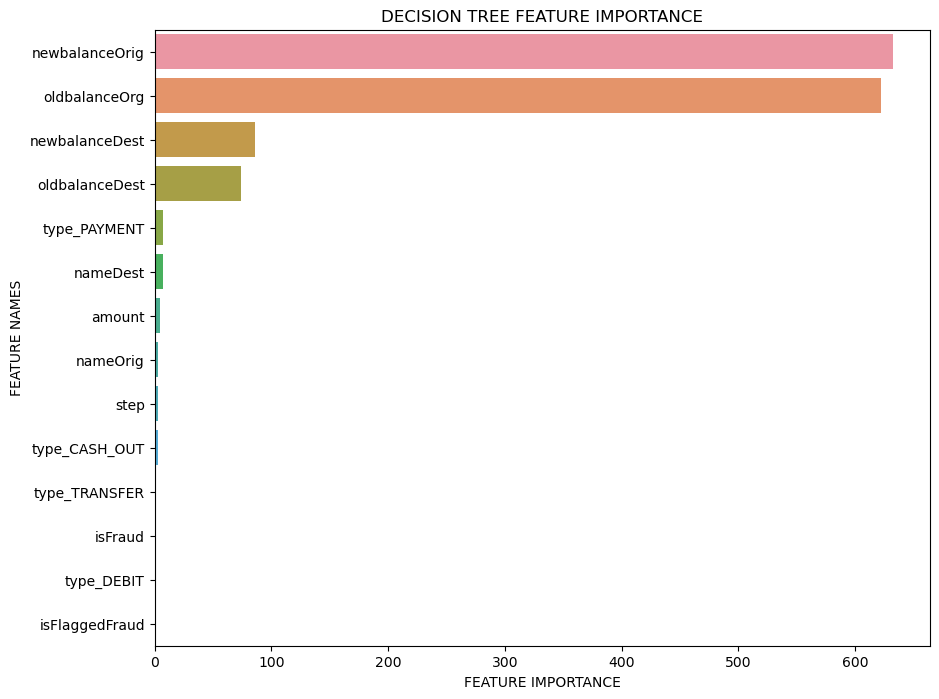

In [273]:
plot_feature_importance(vif_data_sort['VIF'],vif_data_sort['feature'],'DECISION TREE ')

Most research papers consider a VIF (Variance Inflation Factor) > 10 as an indicator of multicollinearity. 

https://quantifyinghealth.com/vif-threshold/

Dangerous variables:

1. oldbalanceorg and newbalanceorig
2. oldbalanceDest and newbalanceDest

Prevention:

For moderate to large sample sizes, the approach to drop one of the correlated variables was established entirely satisfactory to reduce multicollinearity. 

https://www.tandfonline.com/doi/abs/10.1080/09720502.2010.10700699?journalCode=tjim20#:~:text=Multicollinearity%20is%20a%20statistical%20phenomenon%20in%20which%20two%20or%20more,relationships%20among%20the%20explanatory%20variables.

1. drop oldbalnceorg and newbalaceorig and and add the difference of column in the data set.
2. same for oldbalanceDest and newbalanceDest.

In [247]:
old_balance=data["oldbalanceOrg"]  # initial balance before the transaction
new_balance=data["newbalanceOrig"] # new balance after the transaction
bal_change=[] #if balace decrease: 1 else 0
for i in range(len(old_balance)):
    diff=new_balance[i]-old_balance[i]
    if diff>0:
        bal_change.append(1)
    else:
        bal_change.append(0)

In [248]:
print("Balances changed: " + str(bal_change.count(1))+ "\n" + "Balances not changed : " + str(bal_change.count(0)))

Balances changed: 1399253
Balances not changed : 4963367


In [249]:
dest_old=data["oldbalanceDest"] # initial balance recipient before the transaction
dest_new=data["newbalanceDest"] # new balance recipient after the transaction
dest_bal_change=[]
dest_bal=[]
for i in range(len(dest_old)):
    diff=dest_new[i]-dest_old[i]
    dest_bal.append(abs(diff))

In [250]:
data["source_bal_change"]=bal_change
data["destinationBal"]=dest_bal
#data["dest_bal_change"]=dest_bal_change

In [251]:
data.drop(["oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"],axis=1,inplace=True)

In [252]:
data.head()

,step,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,source_bal_change,destinationBal
0,1,9839.64,757869,1662094,0,0,0,0,1,0,0,0.0
1,1,1864.28,2188998,1733924,0,0,0,0,1,0,0,0.0
2,1,181.00,1002156,439685,1,0,0,0,0,1,0,0.0
3,1,181.00,5828262,391696,1,0,1,0,0,0,0,21182.0
4,1,11668.14,3445981,828919,0,0,0,0,1,0,0,0.0


In [253]:
len(data.loc[data.source_bal_change==1])

1399253

In [254]:
data.to_pickle('transaction.pkl')

In [318]:
data=pd.read_pickle('transaction.pkl')
del data['isFlaggedFraud']

In [319]:
data

,step,amount,nameOrig,nameDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,source_bal_change,destinationBal
0,1,9839.64,757869,1662094,0,0,0,1,0,0,0.00
1,1,1864.28,2188998,1733924,0,0,0,1,0,0,0.00
2,1,181.00,1002156,439685,1,0,0,0,1,0,0.00
3,1,181.00,5828262,391696,1,1,0,0,0,0,21182.00
4,1,11668.14,3445981,828919,0,0,0,1,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,5651847,505863,1,1,0,0,0,0,339682.13
6362616,743,6311409.28,1737278,260949,1,0,0,0,1,0,0.00
6362617,743,6311409.28,533958,108224,1,1,0,0,0,0,6311409.27
6362618,743,850002.52,2252932,319713,1,0,0,0,1,0,0.00


DECISION TREE AND RANDOM FOREST 

In [320]:
data

,step,amount,nameOrig,nameDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,source_bal_change,destinationBal
0,1,9839.64,757869,1662094,0,0,0,1,0,0,0.00
1,1,1864.28,2188998,1733924,0,0,0,1,0,0,0.00
2,1,181.00,1002156,439685,1,0,0,0,1,0,0.00
3,1,181.00,5828262,391696,1,1,0,0,0,0,21182.00
4,1,11668.14,3445981,828919,0,0,0,1,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,5651847,505863,1,1,0,0,0,0,339682.13
6362616,743,6311409.28,1737278,260949,1,0,0,0,1,0,0.00
6362617,743,6311409.28,533958,108224,1,1,0,0,0,0,6311409.27
6362618,743,850002.52,2252932,319713,1,0,0,0,1,0,0.00


In [321]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [322]:
# Separating the target variable from the input variables
X = data.iloc[:,[col for col in range(0,11) if col != 4]]
Y = data.values[:,4 ]
  
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)
      

In [323]:
dt=DecisionTreeClassifier(max_depth=4)
dt=dt.fit(X_train,y_train)
dt.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [324]:
predictions=dt.predict(X_test)

In [325]:
dt.predict_proba(X_test)

array([[9.99557782e-01, 4.42218101e-04],
       [9.99557782e-01, 4.42218101e-04],
       [9.99557782e-01, 4.42218101e-04],
       ...,
       [9.99557782e-01, 4.42218101e-04],
       [9.99557782e-01, 4.42218101e-04],
       [9.99557782e-01, 4.42218101e-04]])

In [326]:
accuracy_score(y_test,predictions)

0.9994719156573865

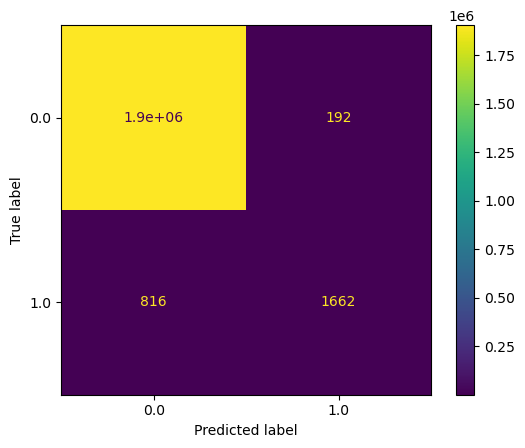

In [327]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cf=confusion_matrix(y_test,predictions,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=dt.classes_)
disp.plot()
plt.show()

In [328]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions,target_names=['NotFraudolent','Fraudolent']))

               precision    recall  f1-score   support

NotFraudolent       1.00      1.00      1.00   1906308
   Fraudolent       0.90      0.67      0.77      2478

     accuracy                           1.00   1908786
    macro avg       0.95      0.84      0.88   1908786
 weighted avg       1.00      1.00      1.00   1908786



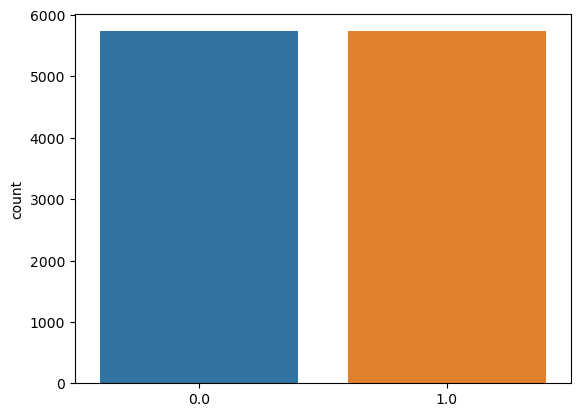

In [329]:
#Undersampling

from imblearn.under_sampling import RandomUnderSampler


rus = RandomUnderSampler()
x_train, y_train = rus.fit_resample(X_train, y_train)

sns.countplot(y_train)
plt.show()

Model Score: 0.9107280753316506
ROC_AUC_Score 0.9035170876375916
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95   1906308
         1.0       0.01      0.90      0.03      2478

    accuracy                           0.91   1908786
   macro avg       0.51      0.90      0.49   1908786
weighted avg       1.00      0.91      0.95   1908786



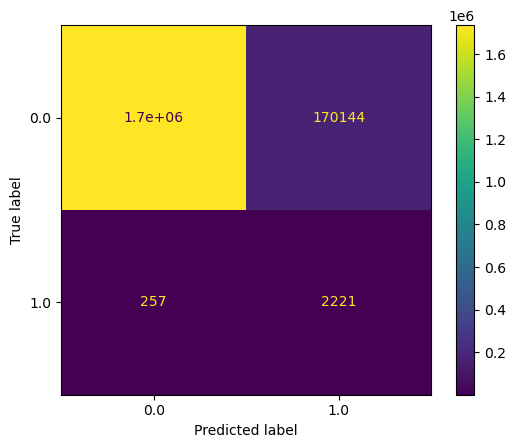

In [330]:
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
pred = dt.predict(X_test)
print('Model Score:', dt.score(X_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

cf=confusion_matrix(y_test,pred,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=dt.classes_)
disp.plot()
plt.show()

In [331]:
#Undersampling do not fit well our data. We are able to improve true positive and negative but paying the trade off 
#of loose recall and precision fit.

In [332]:
# Separating the target variable from the input variables
X = data.iloc[:,[col for col in range(0,11) if col != 4]]
Y = data.values[:,4 ]
  
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)
      

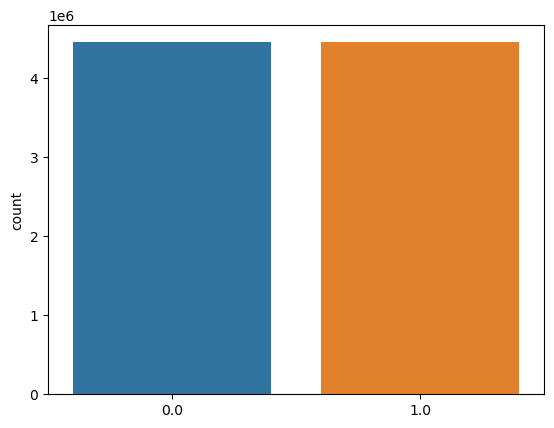

In [334]:
#OverSampling
from imblearn.over_sampling import RandomOverSampler

rus = RandomOverSampler()
x_train, y_train = rus.fit_resample(X_train, y_train)

sns.countplot(y_train)
plt.show()


Model Score: 0.9812786766038728
ROC_AUC_Score 0.8612566080536158
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1906308
         1.0       0.79      0.72      0.76      2478

    accuracy                           1.00   1908786
   macro avg       0.90      0.86      0.88   1908786
weighted avg       1.00      1.00      1.00   1908786



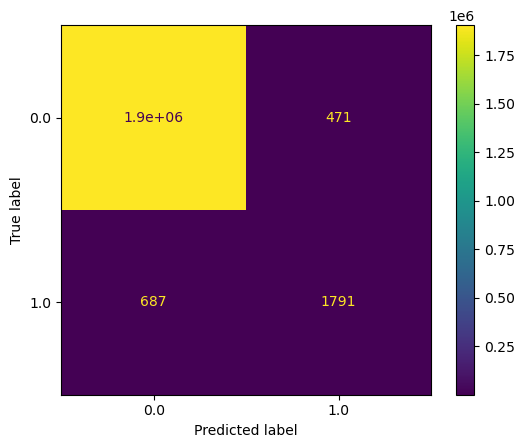

In [342]:
model_ov = DecisionTreeClassifier()
model_ov.fit(x_train, y_train)
pred = dt.predict(X_test)
print('Model Score:', model_ov.score(X_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

cf=confusion_matrix(y_test,pred,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=dt.classes_)
disp.plot()
plt.show()

In [ ]:
#As we can se , respect to the first confusiuon matrix on first DT model we have a lower value of FN but the FP grew up exponentially.
#Let's use the smooten algorithm in order to increase the gap among classes???????????????????????????????????????

Model Score: 0.9812032359834995
ROC_AUC_Score 0.9132082791364352
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99   1906308
         1.0       0.06      0.85      0.10      2478

    accuracy                           0.98   1908786
   macro avg       0.53      0.91      0.55   1908786
weighted avg       1.00      0.98      0.99   1908786



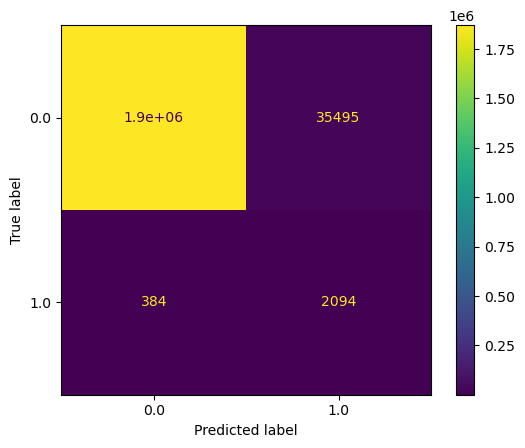

In [336]:
from imblearn.over_sampling import SMOTE


X = data.iloc[:,[col for col in range(0,11) if col != 4]]
Y = data.values[:,4 ]
  
# Splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)


sm = SMOTE(random_state=0)
x_train, y_train = sm.fit_resample(X_train, y_train)

model = DecisionTreeClassifier()
model.fit(x_train, y_train)
pred = model.predict(X_test)
print('Model Score:', model.score(X_test, y_test))

roc_auc = roc_auc_score(y_test, pred)
print('ROC_AUC_Score',roc_auc)

print(classification_report(y_test, pred))

cf=confusion_matrix(y_test,pred,labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cf, display_labels=dt.classes_)
disp.plot()
plt.show()

In the last case, using the Smote methodology we get better results in general than the other simple oversampling and undersampling techniques. It actually makes the quality of the precision metric much worse in order to get better recall than the sample from the original data set. The reason we are satisfied with the last confusion matrix is that in fraud detection we largely prefer to minimize the error in terms of false negatives, partly ignoring the amount of false positives obtained (less critical amount. The context reported here is one of the classic cases of the preference of alarmism over failure to identify positive cases.

In [337]:
feature_names=X.columns
feature_names

Index(['step', 'amount', 'nameOrig', 'nameDest', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER', 'source_bal_change', 'destinationBal'],
      dtype='object')

In [358]:
#feature impportance before SMOTE
feature_importance_dt=pd.DataFrame(dt.feature_importances_,index=feature_names,columns=['Importance_DT'])
#feature_importance_dt

#feature importance on Oversampled dataframe 
feature_importance_ov=pd.DataFrame(model_ov.feature_importances_,index=feature_names,columns=['Importance_DT'])
#feature_importance_ov

feature_importance_dt.compare(feature_importance_ov).rename(columns={'self':'DTree','other':'DT_Oversamp'})


Importance_DT            
                          DTree DT_Oversamp
step                   0.165798    0.168071
amount                 0.267270    0.257381
nameOrig               0.044433    0.058351
nameDest               0.044268    0.039928
type_CASH_OUT          0.168126    0.045120
type_DEBIT             0.000000    0.011805
type_TRANSFER          0.192314    0.209310
source_bal_change      0.013035    0.063383
destinationBal         0.104755    0.146651

<AxesSubplot:>

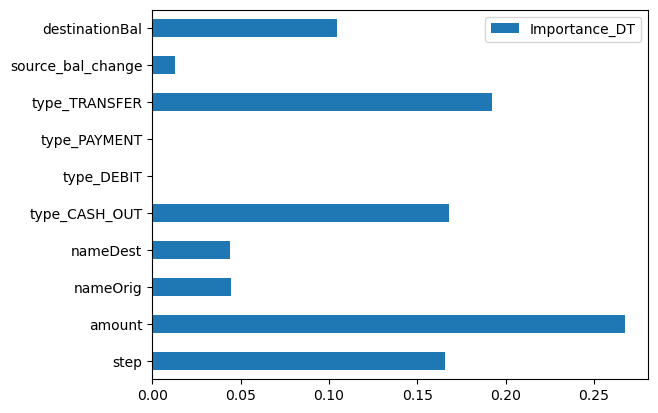

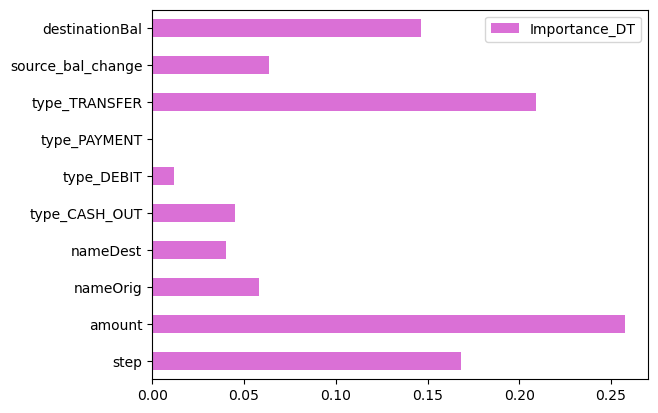

In [359]:
features=list(feature_importance_dt[feature_importance[0]>0].index)
features=list(feature_importance_ov[feature_importance[0]>0].index)
feature_importance_dt.plot.barh()
feature_importance_ov.plot.barh(color='orchid')

In [360]:
data.head(5)

,step,amount,nameOrig,nameDest,isFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,source_bal_change,destinationBal
0,1,9839.64,757869,1662094,0,0,0,1,0,0,0.0
1,1,1864.28,2188998,1733924,0,0,0,1,0,0,0.0
2,1,181.00,1002156,439685,1,0,0,0,1,0,0.0
3,1,181.00,5828262,391696,1,1,0,0,0,0,21182.0
4,1,11668.14,3445981,828919,0,0,0,1,0,0,0.0


In [361]:
del data['type_PAYMENT'] 
del data['type_DEBIT']

In [362]:
#BREVE DESCRIZIONE DELL'INDICE DI GINI

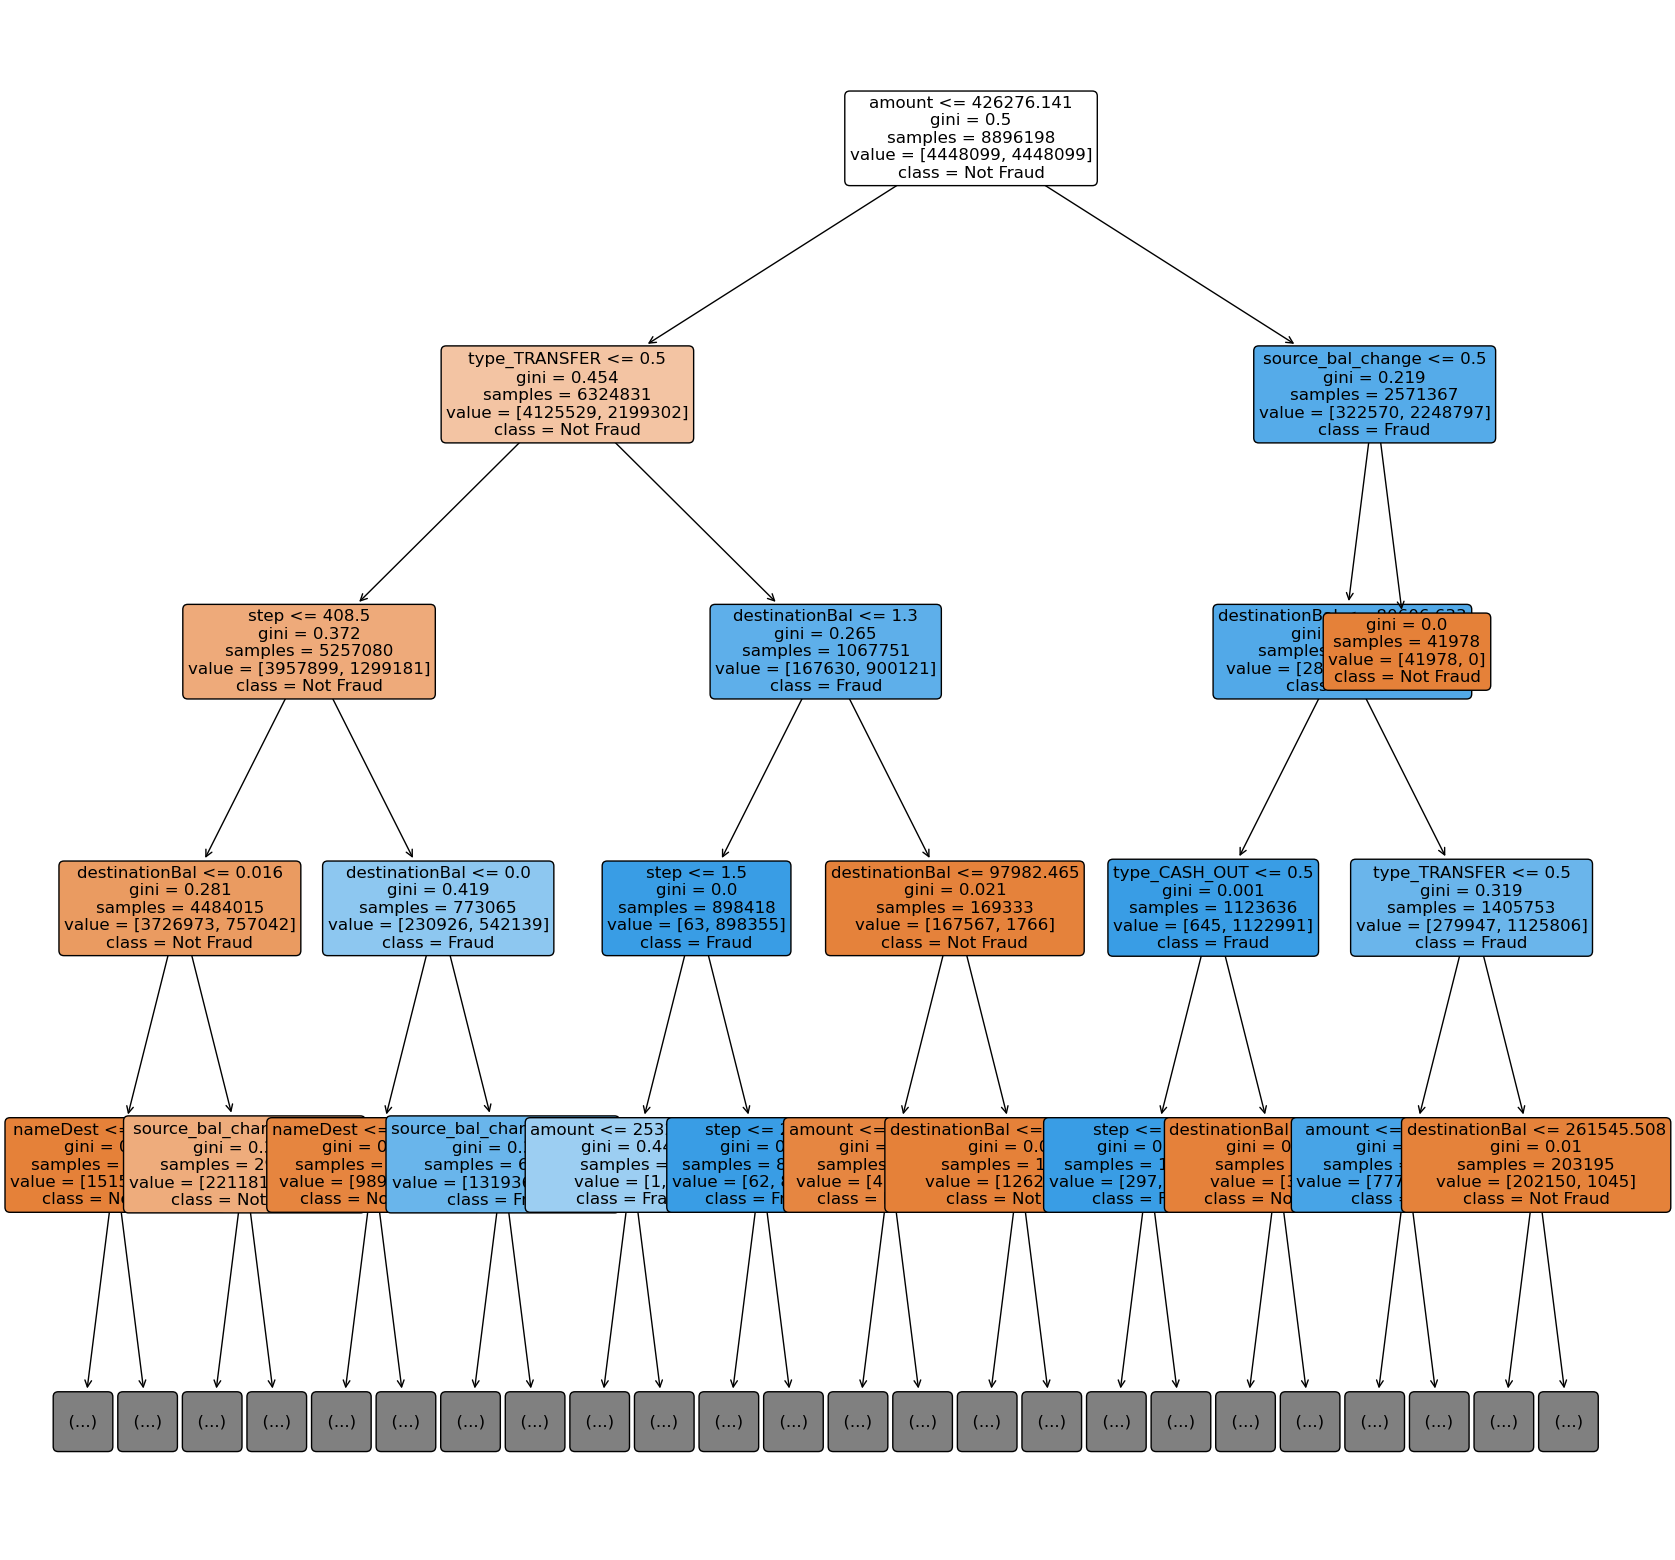

In [365]:
from sklearn import tree
from  matplotlib import pyplot as plt

fig=plt.figure(figsize=(20,20))
_=tree.plot_tree(model_ov,max_depth=4,
                feature_names=feature_names,
                class_names={0:'Not Fraud',1:'Fraud'},
                filled=True,rounded=True,
                fontsize=12)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [ ]:
model = RandomForestClassifier()